In [17]:
import torch
from torch import optim
from reprpo.helpers.scheduler import get_constant_schedule_with_warmup

lr = 3e-4
num_iterations = 1000


num_warmup_steps = int(num_iterations * 0.03)
optimizer = optim.Adam([torch.tensor(0.0)], lr=lr)

In [18]:
from transformers.optimization import get_cosine_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup, get_inverse_sqrt_schedule, get_wsd_schedule

In [29]:
schedulers = {
    # 'cos': optim.lr_scheduler.CosineAnnealingLR(
    #             optim.Adam([torch.tensor(0.0)], lr=lr), T_max=num_iterations, eta_min=0
    #         ),
    # 'coswarmup': optim.lr_scheduler.CosineAnnealingWarmRestarts(
    #             optim.Adam([torch.tensor(0.0)], lr=lr), T_0=100, T_mult=2
    #         ),
    'OneCycleLRdef': optim.lr_scheduler.OneCycleLR(
                optim.Adam([torch.tensor(0.0)], lr=lr),
                lr,
                total_steps=num_iterations,
                verbose=True,
                # pct_start=0.1,
                # final_div_factor=1e2,
            ),
    'OneCycleLRlinear': optim.lr_scheduler.OneCycleLR(
                optim.Adam([torch.tensor(0.0)], lr=lr),
                lr,
                anneal_strategy='linear',
                total_steps=num_iterations,
                verbose=True,
                # pct_start=0.1,
                # final_div_factor=1e2,
            ),
    'OneCycleLR': optim.lr_scheduler.OneCycleLR(
                optim.Adam([torch.tensor(0.0)], lr=lr),
                lr,
                total_steps=num_iterations,
                verbose=True,
                pct_start=0.1,
                final_div_factor=1e2,
            ),
    'OneCycleLR3': optim.lr_scheduler.OneCycleLR(
                optim.Adam([torch.tensor(0.0)], lr=lr),
                lr,
                total_steps=num_iterations,
                verbose=True,
                pct_start=0.1,
                cycle_momentum=False,
                three_phase=True,
            ),
    'OneCycleLR2': optim.lr_scheduler.OneCycleLR(
                optim.Adam([torch.tensor(0.0)], lr=lr),
                lr,
                total_steps=num_iterations,
                verbose=True,
                pct_start=0.1,
                final_div_factor=1e1,
            ),
    'hf_const_warmup': get_constant_schedule_with_warmup(
                optim.Adam([torch.tensor(0.0)], lr=lr), num_warmup_steps=num_warmup_steps
            ),
    'hf_cosine_warm:' : get_cosine_schedule_with_warmup(
                optim.Adam([torch.tensor(0.0)], lr=lr), num_warmup_steps=num_warmup_steps, num_training_steps=num_iterations
            ),
    'hr_poly': get_polynomial_decay_schedule_with_warmup(
                optim.Adam([torch.tensor(0.0)], lr=lr), num_warmup_steps=num_warmup_steps, num_training_steps=num_iterations, lr_end=0.0
            ),
    'hf_inv_sqrt': get_inverse_sqrt_schedule(
                optim.Adam([torch.tensor(0.0)], lr=lr), num_warmup_steps=num_warmup_steps, 
                # num_training_steps=num_iterations
            ),
    'hf_wsd': get_wsd_schedule(
                optim.Adam([torch.tensor(0.0)], lr=lr), num_warmup_steps=num_warmup_steps, 
                num_stable_steps=(num_iterations-num_warmup_steps)//5*4,
                num_decay_steps=(num_iterations-num_warmup_steps)//5,
                # num_training_steps=num_iterations
            ),

}
    

/workspace/repr-preference-optimization/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [30]:
import collections, itertools, functools, re, os

data = collections.defaultdict(list)

for name, scheduler in schedulers.items():
    # print(f'--- {name} ---')
    for i in range(num_iterations):
        r = scheduler.step()
        l = scheduler.optimizer.param_groups[0]['lr']
        data[name].append(l)
        # print(r)
        # 1/0
        # print(f'{i}: {optimizer.param_groups[0]["lr"]:.5f}')
    # print()

/workspace/repr-preference-optimization/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


,OneCycleLRdef,OneCycleLRlinear,OneCycleLR,OneCycleLR3,OneCycleLR2,hf_const_warmup,hf_cosine_warm:,hr_poly,hf_inv_sqrt,hf_wsd
0,1.200795e-05,1.296321e-05,1.207250e-05,1.207250e-05,0.000012,0.00001,1.000000e-05,1.000000e-05,0.000010,1.000000e-05
1,1.203179e-05,1.392642e-05,1.228992e-05,1.228992e-05,0.000012,0.00002,2.000000e-05,2.000000e-05,0.000020,2.000000e-05
2,1.207153e-05,1.488963e-05,1.265204e-05,1.265204e-05,0.000013,0.00003,3.000000e-05,3.000000e-05,0.000030,3.000000e-05
3,1.212716e-05,1.585284e-05,1.315851e-05,1.315851e-05,0.000013,0.00004,4.000000e-05,4.000000e-05,0.000040,4.000000e-05
4,1.219867e-05,1.681605e-05,1.380880e-05,1.380880e-05,0.000014,0.00005,5.000000e-05,5.000000e-05,0.000050,5.000000e-05
...,...,...,...,...,...,...,...,...,...,...
995,1.479562e-08,1.286909e-06,1.282213e-07,1.615289e-09,0.000001,0.00030,1.258727e-08,1.237113e-06,0.000052,3.145761e-07
996,7.242550e-09,8.583394e-07,1.236539e-07,1.384574e-09,0.000001,0.00030,7.080381e-09,9.278351e-07,0.000052,1.769761e-07
997,2.710645e-09,4.297697e-07,1.209135e-07,1.246144e-09,0.000001,0.00030,3.146850e-09,6.185567e-07,0.000052,7.866464e-08
998,1.200000e-09,1.200000e-09,1.200000e-07,1.200000e-09,0.000001,0.00030,7.867145e-10,3.092784e-07,0.000052,1.966745e-08


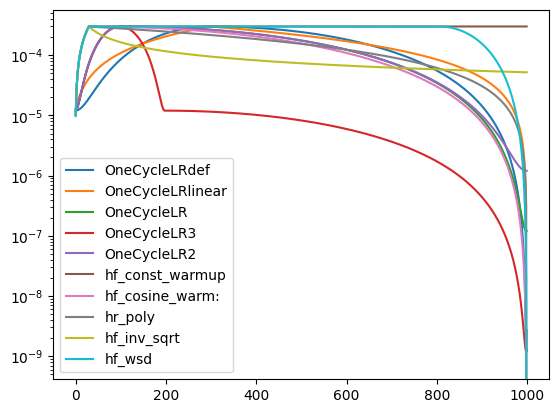

In [31]:
import pandas as pd

df_lr = pd.DataFrame(data)

df_lr.plot(logy=True)
df_lr